## MountainCar-v0

This repository contains a highly optimized implementation of the MountainCar-v0 problem.

Please checkout the [openai]( https://gym.openai.com/envs/MountainCar-v0/) website and ther [github](https://github.com/openai/gym/wiki/) repo for more details on the MountainCar-v0 environmnet.


In [1]:
%matplotlib inline

import numpy as np
import time
import gym
from tqdm import tqdm
from collections import deque
from utils import TileEncoder, plot_var_history

In [2]:
class TO_SARSA_Lambda_agent():
    """
    Agent that learns using True Online SARSA (Lambda) Agent
    """
    def __init__(self, obs_limits, num_actions, epsilon=0.1, step_size=0.5, lambda_val=0.95,
                 discount=1, seed=None, decay_factor=None, num_tilings=8, num_tiles=None):
        # set seed if provided
        self.seed = seed
        self.policy_rand_generator = np.random.default_rng(self.seed)
        # setup tile encoding
        if num_tiles == None:
            num_tiles = [8] * len(obs_limits)
        self.tc = TileEncoder(obs_limits, num_tiles, num_tilings)
        # set agent parameters
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.discount = discount
        self.step_size = step_size/self.tc.num_tilings
        self.d_step_size = self.step_size
        self.decay_factor = decay_factor
        self.value_function = np.zeros((self.num_actions, self.tc.iht_size, self.tc.num_tilings),
                                       dtype=np.float32)
        self.indices = [i for i in range(self.tc.num_tilings)]
        self.episode = 0
        # create experience buffers
        self.state_buffer = deque()
        self.action_buffer = deque()
        self.reward_buffer = deque()
        self.time_step = 0
        self.lambda_val = lambda_val

    def agent_policy(self, state):
        """
        Return an action according to the policy given a state
        """
        if self.policy_rand_generator.random() < self.epsilon:
            # Take random exploratory action
            return self.policy_rand_generator.integers(0, self.num_actions)
        else:
            # Take greedy action w.r.to current value function
            action_vals= np.sum(self.value_function[:, self.tc.get_feature(state), self.indices], axis=1)
            max_val = np.amax(action_vals)
            max_actions = np.where(action_vals == max_val)[0]
            return self.policy_rand_generator.choice(max_actions)

    def start(self, state):
        """ Start the agent for the episode """
        self.episode += 1
        self.state_buffer.append(state)
        self.action_buffer.append(self.agent_policy(state))
        self.trace = np.zeros_like(self.value_function, dtype=np.float32)
        self.Q_Old = 0
        return self.action_buffer[0]
    
    def update_value(self, terminal):
        """Performs an update of the value funciton"""
        # Calculate TD error
        fv = self.tc.get_feature(self.state_buffer[0])
        Q = np.sum(self.value_function[self.action_buffer[0], fv, self.indices])
        if terminal:
            Q_dash = 0
        else:
            fv_dash = self.tc.get_feature(self.state_buffer[1])
            Q_dash = np.sum(self.value_function[self.action_buffer[1], fv_dash, self.indices])
        td_error = (self.reward_buffer[0] + self.discount * Q_dash) - Q
        # Estimate Dutch's trace
        multiplier = self.step_size * self.discount * self.lambda_val
        multiplier = multiplier * np.sum(self.trace[self.action_buffer[0], fv, self.indices])
        self.trace *= self.lambda_val * self.discount
        self.trace[self.action_buffer[0], fv, self.indices] += (1 - multiplier)
        # Update value function
        self.value_function += self.step_size * (td_error + Q - self.Q_Old) * self.trace
        self.value_function[self.action_buffer[0], fv, self.indices] -= self.step_size * (Q-self.Q_Old)
        self.Q_Old = Q_dash
        self.state_buffer.popleft()
        self.action_buffer.popleft()
        self.reward_buffer.popleft()

    def take_step(self, reward, state):
        """
        Agent updates the state values and returns the next action
        """
        self.time_step += 1
        action = self.agent_policy(state)
        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
        # Perform value function update if enough experience is available
        self.update_value(terminal=False)
        return action

    def end(self, reward):
        """
        Terminate the episode and update the values
        """
        self.time_step += 1
        self.reward_buffer.append(reward)
        self.update_value(terminal=True)
        self.reset_episode()

    def reset_episode(self):
        """ Resets episode related parameters of the agent """
        self.state_buffer.clear()
        self.action_buffer.clear()
        self.reward_buffer.clear()
        self.time_step = 0
        if self.decay_factor:
            self.d_step_size = self.d_step_size * self.decay_factor

In [3]:
def run_experient(env, num_runs, num_episodes, settings,render_env = False):
    num_actions = env.action_space.n
    obs_limits = np.transpose(np.vstack((env.observation_space.low, env.observation_space.high)))
    reward_history = []
    for i, (Agent, agent_args) in enumerate(settings):
        time.sleep(1)
        reward_history.append([])
        # Start the runs for each setting
        for run in tqdm(range(1, num_runs+1), desc="Parameter Setting {}".format(i+1)):
            reward_history[i].append([])
            env.seed(run)
            agent_args["seed"] = run
            agent = Agent(obs_limits, num_actions, **agent_args)
            # Start the episodes
            for episode in range(1, num_episodes+1):
                observation  = env.reset()
                done = False
                time_step = 0
                action = agent.start(observation)
                # Start interaction with environment
                while not done:
                    if render_env:
                        env.render()
                        time.sleep(0.001)
                    observation, reward, done, info = env.step(action)
                    time_step +=1
                    if done:
                        agent.end(reward)
                    else:
                        action = agent.take_step(reward, observation)
                reward_history[i][run-1].append(time_step)
    env.close()
    return reward_history, agent

In [4]:
# Setup environment
env = gym.make('MountainCar-v0').env
# Set plot parameters
plot_args = {'x_label': 'Episode', 'y_label': 'Steps per Episode (log scale)\n(Averaged over 50 runs)',
            'log_scale': True, 'y_ticks': [110, 125, 150, 200, 500, 1000]}

## Agent Description:

The agent runs on the True Online SARSA (lambda) algorithm. The agent uses eligibility traces (Dutch's trace) which is a powerful technique to make more directed updates. The agent keeps track of which components of the function approximator contributed to the error in the value estimates. The trace fades away as the agent moves to successive states in the trajectory. 

Another interersting fact is that the agent here looks backwards instead of the usual case where it makes updates by looking forward.

### Hyperparameters:

    - Algorithm: True Online SARSA (lambda) algorithm
    - Step Size - 0.1 (Step size decays exponentially with a factor of 0.99 every timestep)
    - lambda - 0.9
    - epsilon - 0.001
    - Tile Encoder - 16 Tilings with 8 tiles per state space dimension
    - Discount - 1


Parameter Setting 1: 100%|██████████| 100/100 [31:07<00:00, 18.67s/it]


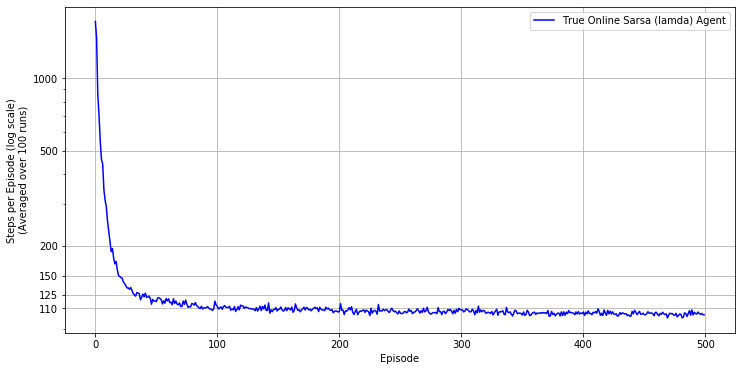

In [5]:
settings = [(TO_SARSA_Lambda_agent, {"step_size": 0.1, "epsilon":0.001, "lambda_val": 0.9, "decay_factor": 0.99, "num_tilings": 16})]

plot_args['y_label'] = 'Steps per Episode (log scale)\n(Averaged over 100 runs)'
plot_labels = ["True Online Sarsa (lamda) Agent"]

rewards_t, agent_t = run_experient(env, 100, 500, settings)

plot_var_history(rewards_t, plot_labels, **plot_args)

#### Note: For further study on eligibility traces, turn to the Chapter-12 of Prof. Sutton's book.

In [9]:
rewards_t[0]

 105,
  88,
  105,
  219,
  106,
  174,
  104,
  90,
  85,
  108,
  105,
  104,
  105,
  105,
  103,
  155,
  101,
  155,
  87,
  90,
  104,
  89,
  103,
  99,
  104,
  104,
  106,
  86,
  104,
  93,
  103,
  85,
  104,
  94,
  103,
  104,
  104,
  188,
  105,
  104,
  94,
  89,
  106,
  90,
  189,
  86,
  105,
  84,
  88,
  105,
  85,
  105,
  106,
  104,
  105,
  105,
  104,
  104,
  103,
  104,
  105,
  90,
  105,
  104,
  103,
  104,
  105,
  105,
  105,
  165,
  102,
  87,
  104,
  105,
  88,
  104,
  103,
  104,
  105,
  101,
  103,
  105,
  105,
  104,
  99,
  104,
  104,
  104,
  84,
  103,
  105,
  105,
  104,
  93,
  88,
  104,
  96,
  105,
  103,
  105,
  105,
  105,
  105,
  105,
  104,
  106,
  104,
  104,
  106,
  103,
  88,
  87,
  103,
  105,
  105,
  85,
  104,
  102,
  103,
  106,
  103,
  103,
  106,
  105,
  102,
  103,
  104,
  89,
  103,
  86,
  105,
  105,
  99,
  105,
  88,
  103,
  108,
  93,
  95,
  104,
  106,
  106,
  102,
  106,
  106,
  103,
  108,
  86,
 